# $k$-Nearest Neighbors (KNN)

## Objectives

- Describe the $k$-nearest neighbors algorithm
- Identify multiple common distance metrics
- Tune $k$ appropriately in response to models with high bias or variance

## Who's Nearby?

One strategy to make predictions on a new data point is to just look at what _similar_ data points are classified as.

### So: What should the grey point be?

![example scenario](images/scenario.png)

## KNN has the following basic steps:

![knn process](images/knn-process.png)

**The algorithm can be summarized as:**

1. A positive integer `k` is specified
2. We select the `k` entries in our training data which are closest to the new sample
3. We find the most common classification of these entries (voting)
4. This is the classification we give to the new sample

**A few other features of KNN:**

* KNN stores the entire training dataset which it uses as its representation
* KNN does not learn any model parameters
* KNN makes predictions 'just-in-time' by calculating the similarity between an input sample and each training instance

**Note:** KNN performs better with a low number of features. The more features you have the more data you need. You increase the dimensions everytime you add another feature. Increase in dimension also leads to the problem of overfitting. To avoid overfitting, the needed data will need to grow exponentially as you increase the number of dimensions. This problem of higher dimension is known as the Curse of Dimensionality.

Resource on the Curse of Dimensionality for classification: https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/

### Voting

How to break ties:

1. When doing a binary classification, often use a odd `k` to avoid ties.
2. Multiple approaches for multi-class problems:
    - Reduce the `k` by 1 to see who wins.
    - Weight the votes based on the distance of the neighbors

## Distance Metrics

When using KNN, we're assuming that _nearby_ points are _similar_ to one another. There are a few different wasy to determine how "close" data points are to one another:

Distance metrics give us formulas to measure the distance between our variables:

![](https://miro.medium.com/max/1400/1*FlMiuoENrq52tMV4S6LSZg.png)

> Euclidean and Manhattan distance are typically best for continuous variables 

## Implementing in Scikit-Learn

Let's try doing some basic classification on some data using the KNN algorithms.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score

In [2]:
# Same processed version of recent Austin Animal Shelter data
# Goal is to predict whether an animal is adopted
df = pd.read_csv("data/processed_shelter.csv")
df.head()

,is_dog,age_in_days,is_female,adoption
0,0,122,0,0
1,1,742,0,0
2,1,742,0,0
3,1,742,1,0
4,1,744,1,0


In [3]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=.2)
X_train.head()

,is_dog,age_in_days,is_female
5,1,746,1
54,1,372,0
275,1,4052,1
884,1,925,1
344,0,97,0


#### Should We Scale?

KNN IS a linear model - you **NEED** to scale your data before fitting a k-nearest neighbors model!

KNN uses distances to determine neighbors, so it's comparing across features - it needs to have a consistent understanding of scale in order to do this appropriately!

In [4]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [5]:
# Instantiate our KNN classifier - can use default k=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_sc, y_train)

print(f"Train Accuracy: {knn.score(X_train_sc, y_train)}")
print(f"Test Accuracy: {knn.score(X_test_sc, y_test)}")

Train Accuracy: 0.8464619492656876
Test Accuracy: 0.7872340425531915


In [6]:
# Evaluate
test_preds = knn.predict(X_test_sc)

print(f'Test Accuracy Score: {accuracy_score(y_test, test_preds)}')
print('-------------------')
print(f'Test Precision Score: {precision_score(y_test, test_preds)}')
print('-------------------')
print(f'Test Recall Score: {recall_score(y_test, test_preds)}')
print('-------------------')
print(f'Test F1_score: {f1_score(y_test, test_preds)}')
print('-------------------')
# Note the different input for ROC-AUC!
print(f'Test ROC-AUC Score: {roc_auc_score(y_test, knn.predict_proba(X_test_sc)[:,1])}')

Test Accuracy Score: 0.7872340425531915
-------------------
Test Precision Score: 0.8175182481751825
-------------------
Test Recall Score: 0.8818897637795275
-------------------
Test F1_score: 0.8484848484848484
-------------------
Test ROC-AUC Score: 0.781657415773848


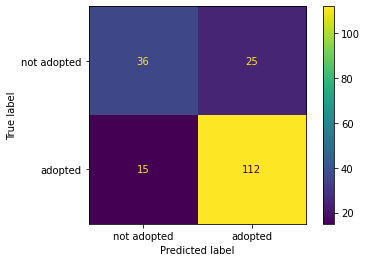

In [7]:
plot_confusion_matrix(knn, X_test_sc, y_test, display_labels=['not adopted', 'adopted']);

## Different $k$ Values

A big factor in this algorithm is choosing $k$

# $k$ and the Bias-Variance Tradeoff

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.25)

In [9]:
# Let's slowly increase k and see what happens to our accuracy scores.

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

k_scores_train = {}
k_scores_val = {}


for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_score_t = []
    accuracy_score_v = []
    for train_ind, val_ind in kf.split(X_train, y_train):
        
        X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind] 
        X_v, y_v = X_train.iloc[val_ind], y_train.iloc[val_ind]
        mm = MinMaxScaler()
        
        X_t_ind = X_t.index
        X_v_ind = X_v.index
        
        X_t = pd.DataFrame(mm.fit_transform(X_t))
        X_t.index = X_t_ind
        X_v = pd.DataFrame(mm.transform(X_v))
        X_v.index = X_v_ind
        
        knn.fit(X_t, y_t)
        
        y_pred_t = knn.predict(X_t)
        y_pred_v = knn.predict(X_v)
        
        accuracy_score_t.append(accuracy_score(y_t, y_pred_t))
        accuracy_score_v.append(accuracy_score(y_v, y_pred_v))
        
        
    k_scores_train[k] = np.mean(accuracy_score_t)
    k_scores_val[k] = np.mean(accuracy_score_v)

In [10]:
k_scores_train

{1: 0.9640271249230847,
 3: 0.8682252713443838,
 5: 0.8404539428194443,
 7: 0.8258492397282433,
 9: 0.8101832645060612,
 11: 0.8009274237032245,
 13: 0.789174770522897,
 15: 0.7756357800318445,
 17: 0.7670923173539878,
 19: 0.7599679017514479}

In [11]:
k_scores_val

{1: 0.7378318135764944,
 3: 0.7776697061803445,
 5: 0.7790881458966565,
 7: 0.7649240121580547,
 9: 0.7606686930091185,
 11: 0.7449949341438703,
 13: 0.7407598784194529,
 15: 0.7336372847011146,
 17: 0.735065856129686,
 19: 0.7151063829787235}

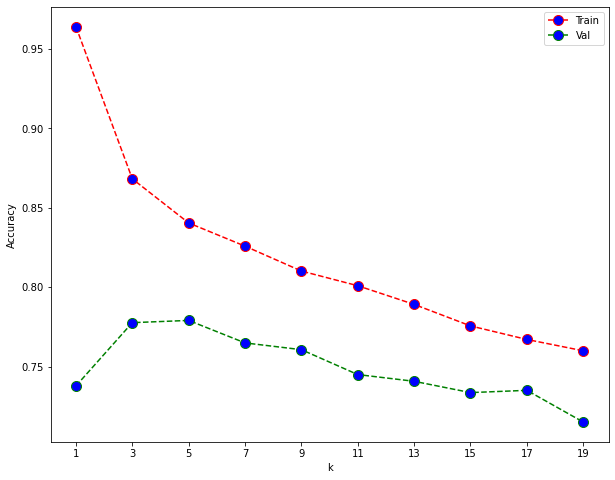

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_val.keys()), list(k_scores_val.values()),
        color='green', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Val')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_xticks(ticks=list(k_scores_val.keys()))
plt.legend();

### Discuss:

- 


## The Relation Between $k$ and Bias/Variance

> Small $k$ values leads to overfitting, but larger $k$ values tend towards underfitting

<img src="images/K-NN_Neighborhood_Size_print.png" width=600>

> From [Machine Learning Flashcards](https://machinelearningflashcards.com/) by Chris Albon

# Summary

K-Nearest Neighbors is a **non-parametric**, **lazy** learning algorithm. 

What does this mean?

- **Non-parametric models** make no underlying assumptions about the distribution of data
- **Lazy learners** (or **instance-based** learning methods) simply store the training examples and postpone the generalization (building a model) until a new instance must be classified or prediction made
    - In other words, no training is necessary! This makes training super fast but testing is slower and costly

## Pros

- Lazy learning (no training phase)
- Simple algorithm to understand and implement

## Cons

- Computationally expensive
    - It doesn't learn anything when the model is `fit` - it just stores all the training data points in memory
    - Thus: high memory requirement, prediction stage can be slow
- Not robust - doesn't generalize well
- Soft boundaries are troublesome
- "Curse of Dimensionality"
    - Sensitive to irrelevant features and the scale of data
    - Thus: doesn't work well with a lot of input features

# Additional Resources

- [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html) (user guide), [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) (class documentation)

- [Videos from An Introduction to Statistical Learning](http://www.dataschool.io/15-hours-of-expert-machine-learning-videos/)
    - Classification Problems and K-Nearest Neighbors (Chapter 2)
    - Introduction to Classification (Chapter 4)
    - Logistic Regression and Maximum Likelihood (Chapter 4)
    
- [Curse of Dimensionality](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)

### More Resources on Scaling:

https://sebastianraschka.com/Articles/2014_about_feature_scaling.html   
http://datareality.blogspot.com/2016/11/scaling-normalizing-standardizing-which.html

# Bonus: Visualize the Decision Boundaries

One way to think about KNN is that there are decision boundaries, areas in which we know exactly what the prediction will be for some given `k`, since we can calculate how many points of each class are nearby. SKLearn and matplotlib can help us visualize this!

Reference: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

In [13]:
# Let's read in the Chemical Manufacturing Process data
chem_df = pd.read_csv("data/ChemicalManufacturingProcess.csv", index_col=0)
chem_df.head()

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial07,BiologicalMaterial08,BiologicalMaterial09,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
0,38.00,6.25,49.58,56.97,12.74,19.51,43.73,100.0,16.66,11.44,...,0.019,0.5,3.0,7.2,NaN,NaN,11.6,3.0,1.8,2.4
1,42.44,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.019,2.0,2.0,7.2,0.1,0.15,11.1,0.9,1.9,2.2
2,42.03,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,0.7,2.0,7.2,0.0,0.00,12.0,1.0,1.8,2.3
3,41.42,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,1.2,2.0,7.2,0.0,0.00,10.6,1.1,1.8,2.1
4,42.49,7.47,63.33,72.25,14.02,17.91,54.66,100.0,18.22,12.80,...,0.017,0.2,2.0,7.3,0.0,0.00,11.0,1.1,1.7,2.1


In [14]:
used_cols = ['BiologicalMaterial01', 'BiologicalMaterial02']
X = chem_df[used_cols]
y = (chem_df['Yield'] >= 41).astype(int)

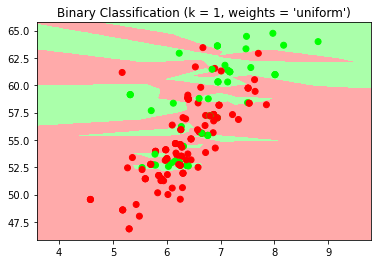

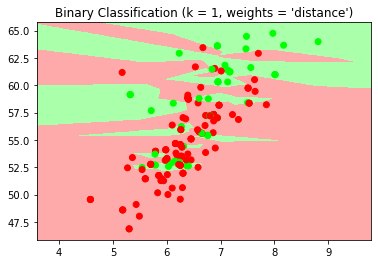

In [17]:
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Can adjust our number of neighbors to explore
n_neighbors = 1

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    y_min, y_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Binary Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

# Level Up: Distance Metrics

> The "closeness" of data points → proxy for similarity

![](img/distances.png)

**Minkowski Distance**:

$$dist(A,B) = (\sum_{k=1}^{N} |a_k - b_k|^c)^\frac{1}{c} $$

Special cases of Minkowski distance are:

- Manhattan: $dist(A,B) = \sum_{k=1}^{N} |a_k - b_k|$


- Euclidean: $dist(A,B) = \sqrt{ \sum_{k=1}^{N} (a_k - b_k)^2 }$

There are quite a few different distance metrics built-in for Scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html 